In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize pixel values (0-255) to (0-1)
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Expand dimensions to match the expected input shape for the model (28, 28, 1)
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# Split training data into training and validation sets
val_images = train_images[:12000]
val_labels = train_labels[:12000]
train_images = train_images[12000:]
train_labels = train_labels[12000:]

# One-hot encode labels for digit classification
train_labels_categorical = to_categorical(train_labels, 10)
val_labels_categorical = to_categorical(val_labels, 10)
test_labels_categorical = to_categorical(test_labels, 10)

# Create parity labels (even=1, odd=0)
train_parity = np.where(train_labels % 2 == 0, 1, 0)
val_parity = np.where(val_labels % 2 == 0, 1, 0)
test_parity = np.where(test_labels % 2 == 0, 1, 0)

# Ensure parity labels are properly shaped
train_parity = train_parity.reshape(-1, 1)
val_parity = val_parity.reshape(-1, 1)
test_parity = test_parity.reshape(-1, 1)

# Define a function for manual data augmentation
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.rot90(image, k=np.random.randint(4))  # Random rotations by 90 degrees
    return image

# Apply the augmentation function to the training images
train_images_augmented = np.array([augment_image(img).numpy() for img in train_images])

# Define the input
input_layer = Input(shape=(28, 28, 1))

# Shared layers (VGG-like block)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.4)(x)

# Digit classification branch
digit_classification_branch = Dense(128, activation='relu')(x)
digit_classification_branch = Dropout(0.4)(digit_classification_branch)
digit_classification_output = Dense(10, activation='softmax', name='digit_classification')(digit_classification_branch)

# Parity prediction branch
parity_prediction_branch = Dense(128, activation='relu')(x)
parity_prediction_branch = Dropout(0.4)(parity_prediction_branch)
parity_prediction_output = Dense(1, activation='sigmoid', name='parity_prediction')(parity_prediction_branch)

# Combine branches into a model
model = Model(inputs=input_layer, outputs=[digit_classification_output, parity_prediction_output])

# Compile the model with a different optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss={'digit_classification': 'categorical_crossentropy', 'parity_prediction': 'binary_crossentropy'},
    metrics={'digit_classification': 'accuracy', 'parity_prediction': 'accuracy'}
)

# Print the model summary
model.summary()

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=0.00001)

# Training the model with augmented data
history = model.fit(
    train_images_augmented,
    {'digit_classification': train_labels_categorical, 'parity_prediction': train_parity},
    validation_data=(val_images, {'digit_classification': val_labels_categorical, 'parity_prediction': val_parity}),
    epochs=30,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 28, 28, 32)           320       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_9 (Bat  (None, 28, 28, 32)           128       ['conv2d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 14, 14, 32)           0         ['batch_normalization_9[

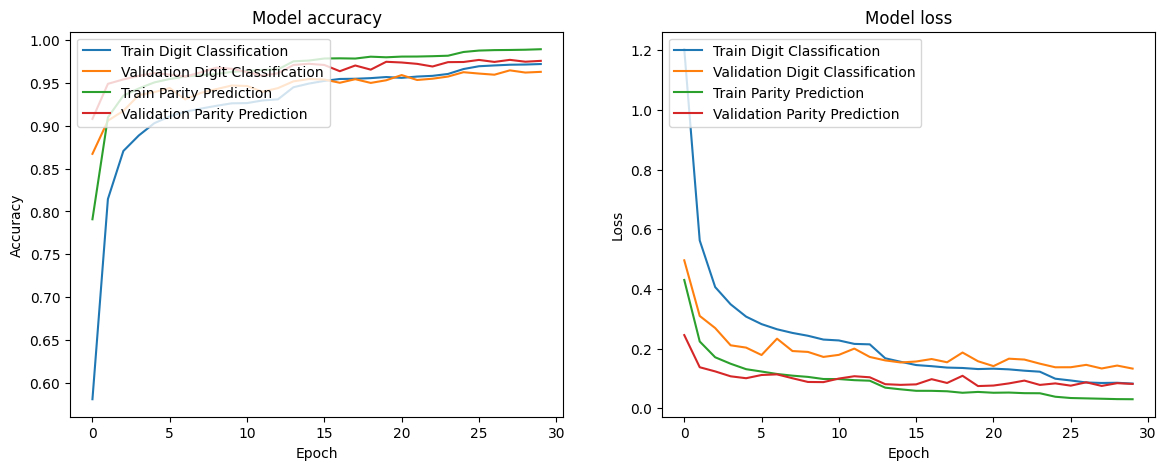

In [7]:
import matplotlib.pyplot as plt
-
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['digit_classification_accuracy'])
plt.plot(history.history['val_digit_classification_accuracy'])
plt.plot(history.history['parity_prediction_accuracy'])
plt.plot(history.history['val_parity_prediction_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Digit Classification', 'Validation Digit Classification', 'Train Parity Prediction', 'Validation Parity Prediction'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['digit_classification_loss'])
plt.plot(history.history['val_digit_classification_loss'])
plt.plot(history.history['parity_prediction_loss'])
plt.plot(history.history['val_parity_prediction_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Digit Classification', 'Validation Digit Classification', 'Train Parity Prediction', 'Validation Parity Prediction'], loc='upper left')

plt.show()


313/313 [==============================] - 12s 38ms/step


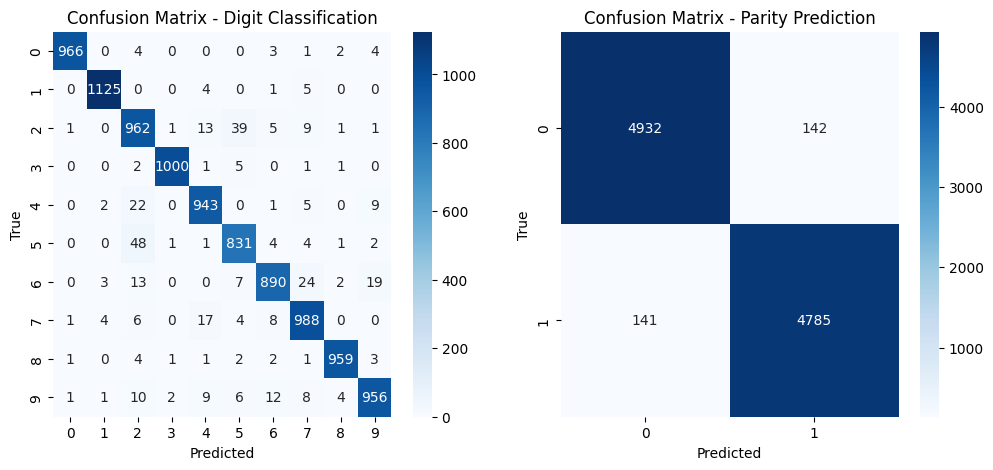

Digit Classification - Accuracy: 0.9620, Precision: 0.9619, Recall: 0.9613
Parity Prediction - Accuracy: 0.9717, Precision: 0.9712, Recall: 0.9714


In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns

# Predict on the test data
predictions = model.predict(test_images)
digit_predictions = np.argmax(predictions[0], axis=1)
parity_predictions = (predictions[1] > 0.5).astype(int)

# Confusion matrix for digit classification
cm_digit = confusion_matrix(test_labels, digit_predictions)
cm_parity = confusion_matrix(test_parity, parity_predictions)

# Plot confusion matrix for digit classification
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_digit, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Digit Classification')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot confusion matrix for parity prediction
plt.subplot(1, 2, 2)
sns.heatmap(cm_parity, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Parity Prediction')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

# Calculate metrics
digit_accuracy = accuracy_score(test_labels, digit_predictions)
digit_precision = precision_score(test_labels, digit_predictions, average='macro')
digit_recall = recall_score(test_labels, digit_predictions, average='macro')

parity_accuracy = accuracy_score(test_parity, parity_predictions)
parity_precision = precision_score(test_parity, parity_predictions)
parity_recall = recall_score(test_parity, parity_predictions)

print(f"Digit Classification - Accuracy: {digit_accuracy:.4f}, Precision: {digit_precision:.4f}, Recall: {digit_recall:.4f}")
print(f"Parity Prediction - Accuracy: {parity_accuracy:.4f}, Precision: {parity_precision:.4f}, Recall: {parity_recall:.4f}")


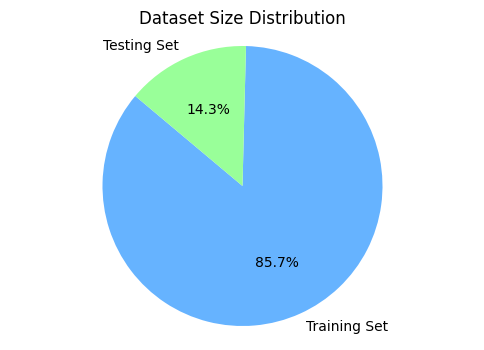

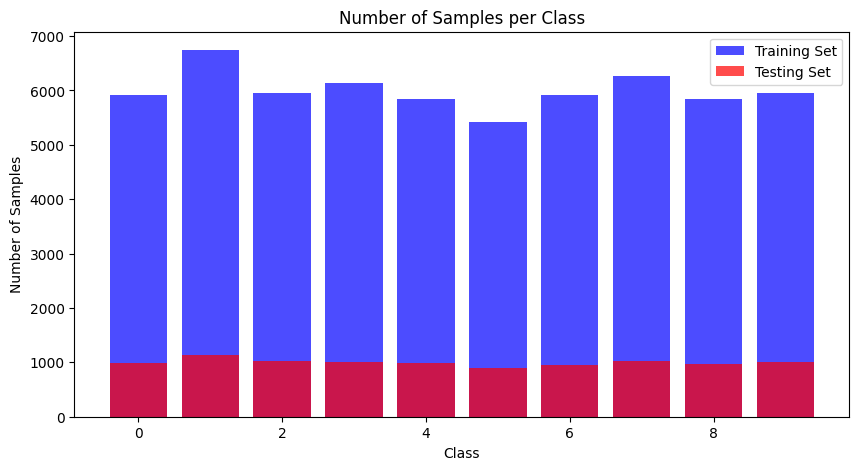

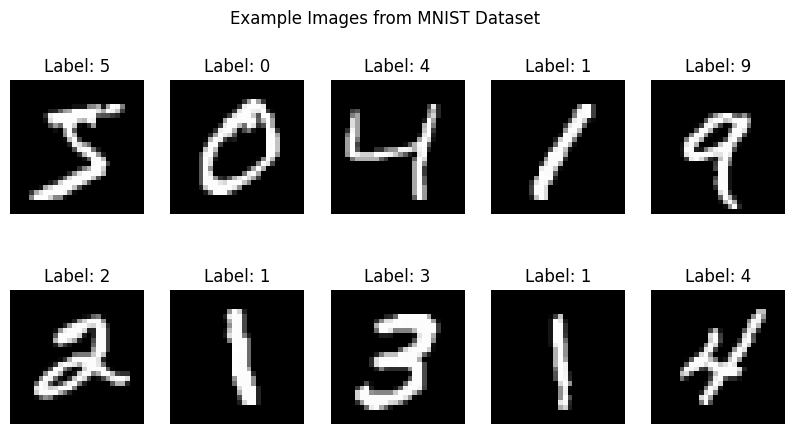

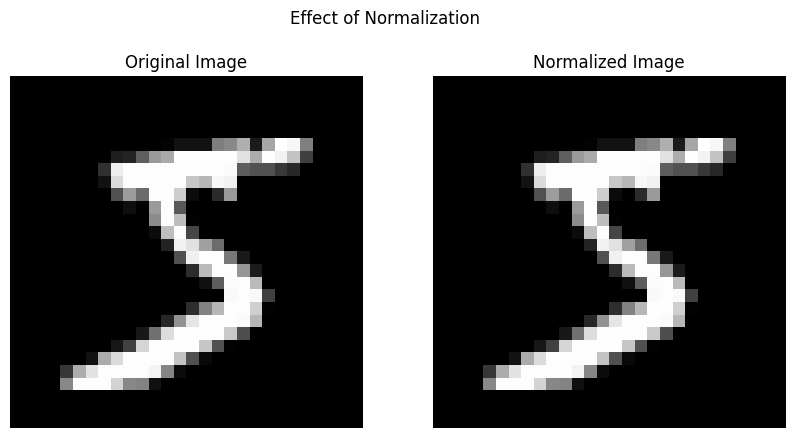

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize pixel values (0-255) to (0-1)
train_images_norm = train_images.astype('float32') / 255.0
test_images_norm = test_images.astype('float32') / 255.0

# Dataset size visualization
def dataset_size_plot(train_size, test_size):
    labels = ['Training Set', 'Testing Set']
    sizes = [train_size, test_size]
    plt.figure(figsize=(6, 4))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99'])
    plt.title('Dataset Size Distribution')
    plt.axis('equal')
    plt.show()

# Number of samples per class
def samples_per_class_plot(train_labels, test_labels):
    classes, train_counts = np.unique(train_labels, return_counts=True)
    _, test_counts = np.unique(test_labels, return_counts=True)

    plt.figure(figsize=(10, 5))
    plt.bar(classes, train_counts, alpha=0.7, label='Training Set', color='b')
    plt.bar(classes, test_counts, alpha=0.7, label='Testing Set', color='r')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Number of Samples per Class')
    plt.legend()
    plt.show()

# Snapshot of example images
def example_images_plot(images, labels):
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle('Example Images from MNIST Dataset')
    plt.show()

# Normalization effect
def normalization_effect_plot(original_image, normalized_image):
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Normalized Image
    plt.subplot(1, 2, 2)
    plt.imshow(normalized_image, cmap='gray')
    plt.title('Normalized Image')
    plt.axis('off')

    plt.suptitle('Effect of Normalization')
    plt.show()

# Generate the plots
dataset_size_plot(len(train_images), len(test_images))
samples_per_class_plot(train_labels, test_labels)
example_images_plot(train_images, train_labels)
normalization_effect_plot(train_images[0], train_images_norm[0])
